In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import pickle
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('/kaggle/input/pickle-files/Image_Data_256x256.pkl', 'rb') as file:
    data =  pickle.load(file)

In [3]:
bbox_folder = '/kaggle/input/large-scale-image-dataset-of-wood-surface-defects/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))
len(bb_paths)

4000

In [5]:
path = "/kaggle/input/large-scale-image-dataset-of-wood-surface-defects/Images - 1/Images - 1"
image_paths = glob(os.path.join(path,'*.jpg'))

bbox_folder = '/kaggle/input/large-scale-image-dataset-of-wood-surface-defects/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))


Image_data = []
Label_data = []
Image_path = []

for i in bb_paths:
    if os.path.exists(i):
        if os.path.getsize(i) == 0:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.bilateralFilter(data[bb_paths.index(i)], 9, 75, 75))
            Label_data.append('0')
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.GaussianBlur(data[bb_paths.index(i)], (5, 5), 0))
            Label_data.append('0') 
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.magnitude(cv2.Sobel(data[bb_paths.index(i)], cv2.CV_64F, 1, 0, ksize=3), cv2.Sobel(data[bb_paths.index(i)], cv2.CV_64F, 0, 1, ksize=3)))
            Label_data.append('0')
        else:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(data[bb_paths.index(i)])
            Label_data.append('1')
                

In [6]:
df = pd.DataFrame({'Image': Image_data, 'Label': Label_data})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   4776 non-null   object
 1   Label   4776 non-null   object
dtypes: object(2)
memory usage: 74.8+ KB


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Features = np.stack(df['Image'].values)
Target = np.stack(df['Label'].values)
x_train, x_test, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.2,random_state=666)
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [9]:
x_train = x_train.reshape(x_train.shape[0], *(256, 256, 3))
x_test = x_test.reshape(x_test.shape[0], *(256, 256, 3))

## VGG19

In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout


from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

input_shape = (256, 256, 3)

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg19_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19_model)
model.add(Flatten())


# model.add(Dense(1024, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))  

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))  

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [11]:
features = model.predict(x_train)
x_test_features = model.predict(x_test)

30/30 [==============================] - 10s 347ms/step


In [ ]:
# VGG19 - 2class prediction

# from sklearn.metrics import accuracy_score, f1_score
# y_test = np.argmax(y_test,axis=1)
# x_test_features = np.argmax(x_test_features,axis=1)
# print(accuracy_score(y_test, x_test_features))
# print(f1_score(y_test,x_test_features,average="weighted"))

# 49%

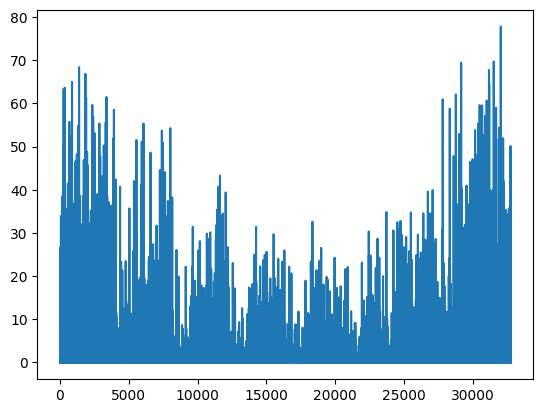

In [12]:
features = features.reshape((features.shape[0], -1))
x_test_features = x_test_features.reshape((x_test_features.shape[0], -1))
plt.plot(features[311])

## PCA

In [57]:
from sklearn.decomposition import PCA

n_components = len(x_test_features)

pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features)
x_test_features_pca = pca.fit_transform(x_test_features)

In [58]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(features_pca, y_train)
y_pred = knn_model.predict(x_test_features_pca)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.8535564853556485
0.859438428663815


## Kernal PCA

In [59]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)

features_kpca = pca.fit_transform(features)
x_test_features_kpca = pca.fit_transform(x_test_features)

In [60]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(features_kpca, y_train)
y_pred = knn_model.predict(x_test_features_kpca)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.8598326359832636
0.8646572357822757


0.9299163179916318
0.9329210978213291


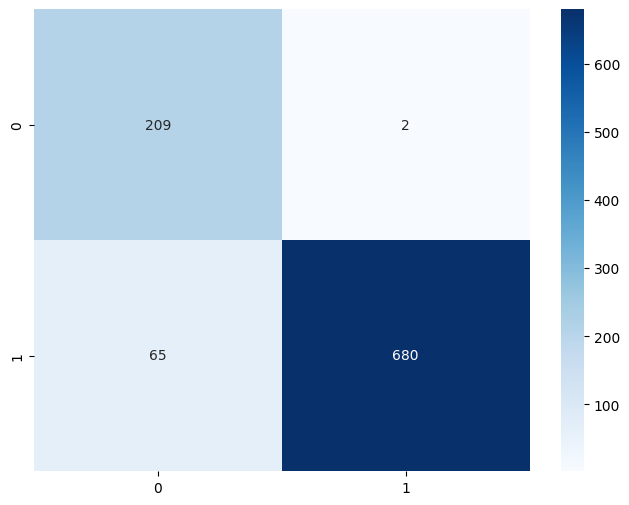

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(features, y_train)
y_pred = knn_model.predict(x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [20]:
from sklearn.linear_model import Lasso

alpha = 0.01 ## Increasing makes more features sparse
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(features, y_train)
klp = lasso_model.predict(x_test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.517e-01, tolerance: 7.152e-02
  model = cd_fast.enet_coordinate_descent(


In [21]:
Lasso_features = []
for i in features:
    Lasso_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_features = np.array(Lasso_features)

Lasso_x_test_features = []
for i in x_test_features:
    Lasso_x_test_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_x_test_features = np.array(Lasso_x_test_features)

In [22]:
print(f'{len(features[0])},{len(Lasso_features[0])}')

32768,1005


0.9769874476987448
0.9773174572494088


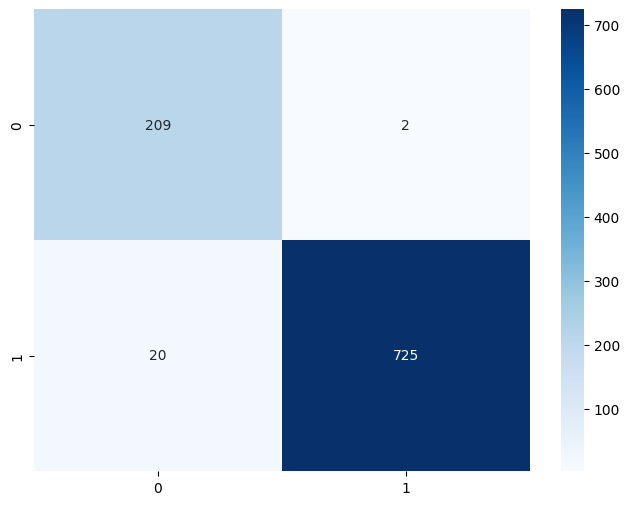

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(Lasso_features, y_train)
y_pred = knn_model.predict(Lasso_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [24]:
from scipy.optimize import minimize

def objective_function(x, A, b, lambd):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lambd * np.linalg.norm(x, 1)

def proximal_gradient_descent_scipy(A, b, lambd, x0, max_iter=10, tol=1e-4):
    result = minimize(
        fun=objective_function,
        x0=x0,
        args=(A, b, lambd),
        method='L-BFGS-B',  
        options={'maxiter': max_iter, 'disp': True}
    )

    return result.x

A = np.matrix(Lasso_features)
b = np.matrix(np.argmax(y_train, axis=1))

resulting_coefficients = proximal_gradient_descent_scipy(A, b, lambd=0.1, x0=np.zeros(A.shape[1]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1005     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43350D+03    |proj g|=  1.96723D+05


 This problem is unconstrained.



At iterate    1    f=  2.97882D+02    |proj g|=  4.30769D+04

At iterate    2    f=  2.70416D+02    |proj g|=  3.82901D+04

At iterate    3    f=  1.34216D+02    |proj g|=  8.34220D+03

At iterate    4    f=  1.09112D+02    |proj g|=  7.25848D+03

At iterate    5    f=  5.45508D+01    |proj g|=  3.57283D+03

At iterate    6    f=  4.21275D+01    |proj g|=  1.79188D+03

At iterate    7    f=  2.97452D+01    |proj g|=  1.36663D+03

At iterate    8    f=  2.42952D+01    |proj g|=  1.25430D+03

At iterate    9    f=  1.79705D+01    |proj g|=  6.96025D+02

At iterate   10    f=  1.63918D+01    |proj g|=  8.44317D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [25]:
rc = np.round(resulting_coefficients,3)
sum(rc!=0)

124

In [26]:
PGD_features = []
for i in Lasso_features:
    PGD_features.append(np.array(i[rc != 0]))
PGD_features = np.array(PGD_features)

PGD_x_test_features = []
for i in Lasso_x_test_features:
    PGD_x_test_features.append(np.array(i[rc != 0]))
PGD_x_test_features = np.array(PGD_x_test_features)

0.9989539748953975
0.9989548600808168


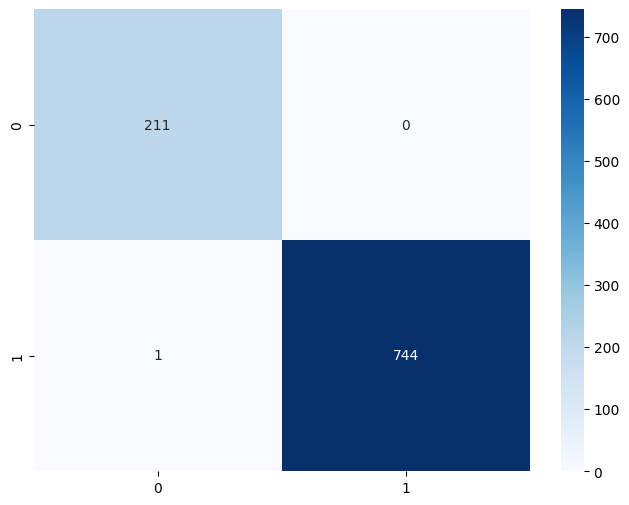

In [52]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(PGD_features, y_train)
y_pred = knn_model.predict(PGD_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

0.8891213389121339
0.8898535006763397


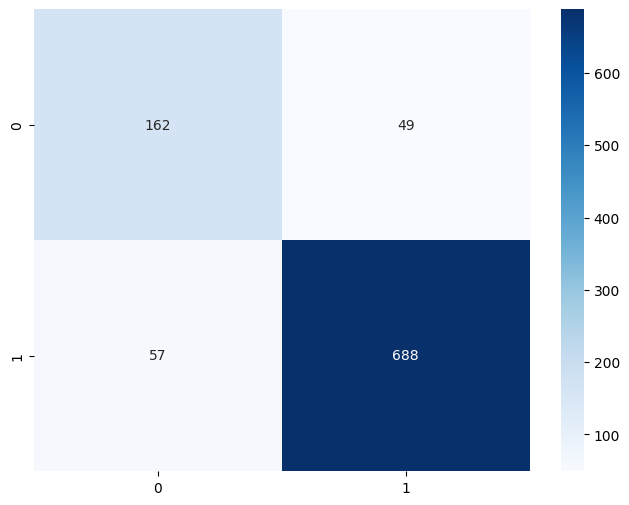

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       211
           1       0.93      0.92      0.93       745

    accuracy                           0.89       956
   macro avg       0.84      0.85      0.84       956
weighted avg       0.89      0.89      0.89       956



In [36]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.25)  # Adjust contamination based on your dataset
isolation_forest.fit(PGD_features)

# Predict outliers/anomalies
outlier_predictions = isolation_forest.predict(PGD_x_test_features)

# Convert predictions to binary labels (1 for inliers, -1 for outliers)
anomaly_labels = (outlier_predictions == 1).astype(int)

y_pred = anomaly_labels
y_tests = np.argmax(y_test, axis=1)
print(accuracy_score(y_tests, y_pred))
print(f1_score(y_tests,y_pred,average="weighted"))

cm = confusion_matrix(y_tests, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()
print(classification_report(y_tests, y_pred))

0.7039748953974896
0.6591357147384977


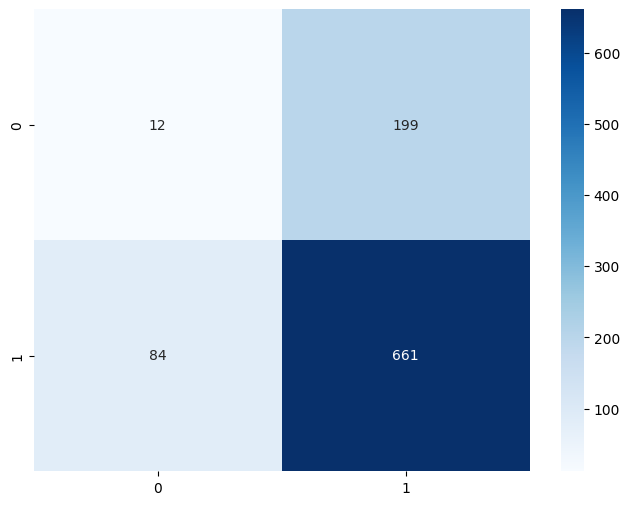

In [51]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

# Assuming 'features' contains your 600 features for each image
# Reshape the features if needed
features = features.reshape((len(PGD_features), -1))

# Create and fit the LOF model
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)  # Adjust parameters as needed
outlier_scores = lof.fit_predict(PGD_x_test_features)

# Convert LOF scores to binary labels (1 for inliers, -1 for outliers)
anomaly_labels = (outlier_scores == 1).astype(int)

y_pred = anomaly_labels
print(accuracy_score(y_tests, y_pred))
print(f1_score(y_tests,y_pred,average="weighted"))

cm = confusion_matrix(y_tests, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

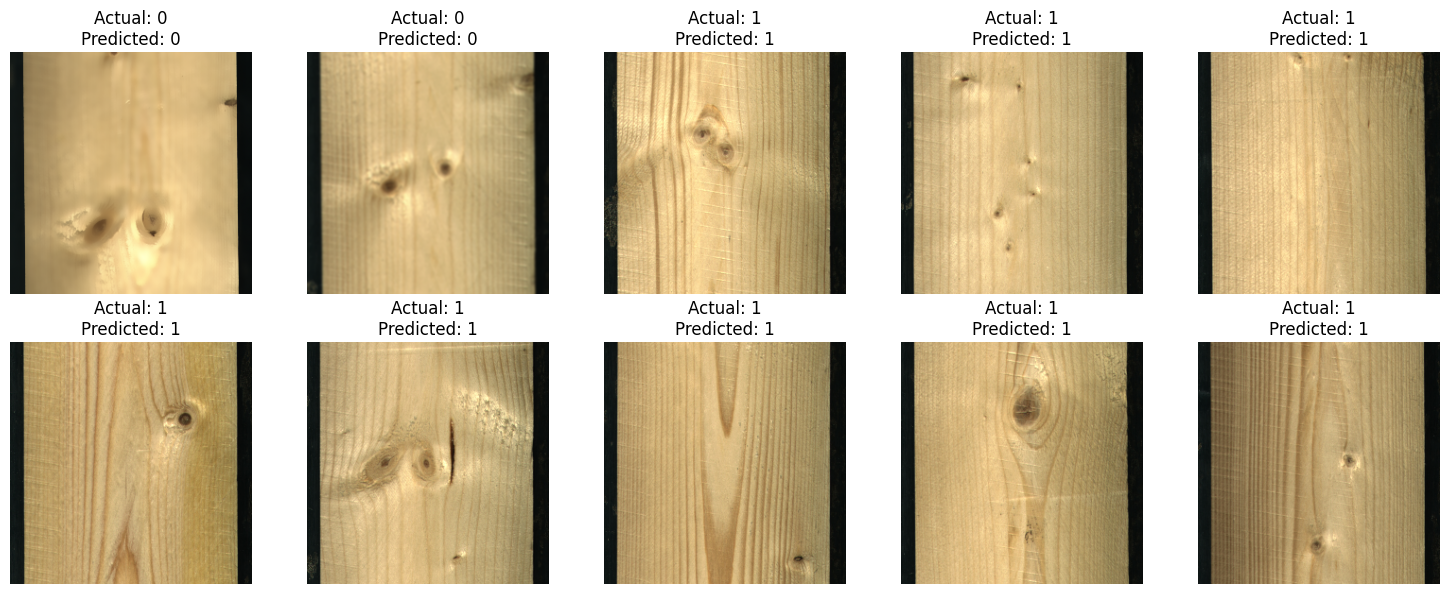

In [56]:
yt = np.argmax(y_test, axis=1)
yp = np.argmax(y_pred, axis=1)

k = np.random.randint(0, len(yt), size=10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in zip(k, axes.flatten()):
    ax.imshow(x_test[i] / 255)
    ax.set_title(f'Actual: {yt[i]}\nPredicted: {yp[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()